# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

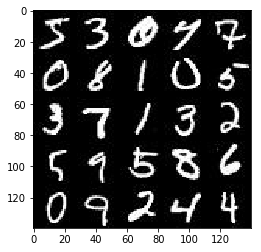

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

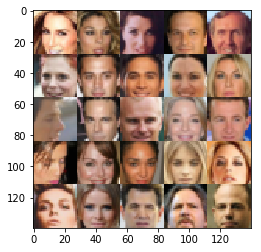

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, ())
    return inputs, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [31]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Here is the PRelu slope
    alpha = 0.2
    n_filters=[64, 128, 256]
    w_size = 5
    h = images
    with tf.variable_scope('discriminator', reuse=reuse):
        for layer_i, n_output in enumerate(n_filters):
            h = tf.layers.conv2d(h, n_output, w_size, strides=2, padding='same')
            h = tf.layers.batch_normalization(h, training=True)
            h = tf.maximum(alpha * h, h)
            
        # Get the dimensions for flatten afterwards
        dims = h.get_shape().as_list()
        flattened = tf.reshape(h, shape=[-1, dims[1] * dims[2] * dims[3]])
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        
        # print the last second dimension
        print('the last second dimension of discriminator is :', dims)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

the last second dimension of discriminator is : [None, 4, 4, 256]
the last second dimension of discriminator is : [None, 4, 4, 256]
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [32]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    n_filters=[128, 64]
    w_size = 5
    initialmap_size = 7
    n_filters.append(out_channel_dim)
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # Here I match the input size using the last second layer of discriminator
        h = tf.layers.dense(z, initialmap_size*initialmap_size*n_filters[0])
        h = tf.reshape(h, (-1, initialmap_size, initialmap_size, n_filters[0]))
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
        
        for layer_i, n_output in enumerate(n_filters[1:-1]):
            h = tf.layers.conv2d_transpose(h, n_output, w_size, strides=2, padding='same')
            h = tf.layers.batch_normalization(h, training=is_train)
            h = tf.maximum(alpha * h, h)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h, n_filters[-1], w_size, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # the discriminator is shared between real data and fake data
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # The discriminator tries to have a task like classification
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    # the aim of generator is to confuse the discriminator for simulated fake data
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

the last second dimension of discriminator is : [None, 4, 4, 256]
the last second dimension of discriminator is : [None, 4, 4, 256]
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    print_every = 10
    show_every = 100
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images, 
                    input_z: batch_z, 
                    lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z, 
                    input_real: batch_images, 
                    lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

the last second dimension of discriminator is : [None, 4, 4, 256]
the last second dimension of discriminator is : [None, 4, 4, 256]
Epoch 1/2... Discriminator Loss: 0.4036... Generator Loss: 3.3214
Epoch 1/2... Discriminator Loss: 0.4286... Generator Loss: 2.6948
Epoch 1/2... Discriminator Loss: 0.3848... Generator Loss: 3.5445
Epoch 1/2... Discriminator Loss: 0.3986... Generator Loss: 3.1265
Epoch 1/2... Discriminator Loss: 0.4098... Generator Loss: 3.0195
Epoch 1/2... Discriminator Loss: 0.3794... Generator Loss: 3.6525
Epoch 1/2... Discriminator Loss: 0.4972... Generator Loss: 2.3121
Epoch 1/2... Discriminator Loss: 0.3942... Generator Loss: 4.4086
Epoch 1/2... Discriminator Loss: 0.4097... Generator Loss: 3.2242
Epoch 1/2... Discriminator Loss: 1.3201... Generator Loss: 0.8728


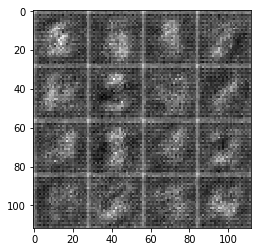

Epoch 1/2... Discriminator Loss: 0.4844... Generator Loss: 2.4358
Epoch 1/2... Discriminator Loss: 0.5397... Generator Loss: 2.0606
Epoch 1/2... Discriminator Loss: 0.4351... Generator Loss: 3.7580
Epoch 1/2... Discriminator Loss: 0.4617... Generator Loss: 2.7995
Epoch 1/2... Discriminator Loss: 0.4766... Generator Loss: 2.8468
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 0.4500... Generator Loss: 3.0726
Epoch 1/2... Discriminator Loss: 0.4658... Generator Loss: 2.4417
Epoch 1/2... Discriminator Loss: 0.5367... Generator Loss: 1.9893
Epoch 1/2... Discriminator Loss: 0.7869... Generator Loss: 4.5753


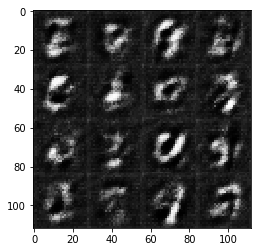

Epoch 1/2... Discriminator Loss: 0.4718... Generator Loss: 2.4468
Epoch 1/2... Discriminator Loss: 0.5635... Generator Loss: 2.8555
Epoch 1/2... Discriminator Loss: 0.5382... Generator Loss: 1.9960
Epoch 1/2... Discriminator Loss: 0.8412... Generator Loss: 1.0745
Epoch 1/2... Discriminator Loss: 0.4673... Generator Loss: 2.5258
Epoch 1/2... Discriminator Loss: 0.4976... Generator Loss: 2.5653
Epoch 1/2... Discriminator Loss: 0.5517... Generator Loss: 2.6407
Epoch 1/2... Discriminator Loss: 0.5090... Generator Loss: 2.4096
Epoch 1/2... Discriminator Loss: 0.5373... Generator Loss: 1.9445
Epoch 1/2... Discriminator Loss: 0.5090... Generator Loss: 3.1562


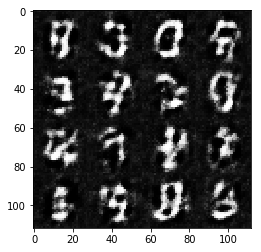

Epoch 1/2... Discriminator Loss: 0.6908... Generator Loss: 3.6163
Epoch 1/2... Discriminator Loss: 0.5665... Generator Loss: 2.4254
Epoch 1/2... Discriminator Loss: 0.4805... Generator Loss: 2.4418
Epoch 1/2... Discriminator Loss: 0.4605... Generator Loss: 2.5642
Epoch 1/2... Discriminator Loss: 0.5055... Generator Loss: 2.1858
Epoch 1/2... Discriminator Loss: 0.5064... Generator Loss: 2.9421
Epoch 1/2... Discriminator Loss: 0.4512... Generator Loss: 2.9688
Epoch 1/2... Discriminator Loss: 0.4833... Generator Loss: 3.1930
Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 2.4404
Epoch 1/2... Discriminator Loss: 0.8378... Generator Loss: 1.1956


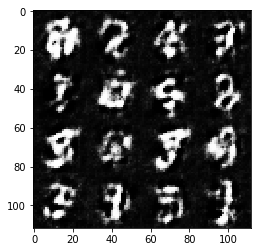

Epoch 1/2... Discriminator Loss: 0.4737... Generator Loss: 2.6460
Epoch 1/2... Discriminator Loss: 0.5145... Generator Loss: 2.2240
Epoch 1/2... Discriminator Loss: 0.4793... Generator Loss: 2.3476
Epoch 1/2... Discriminator Loss: 0.4525... Generator Loss: 2.7304
Epoch 1/2... Discriminator Loss: 0.4272... Generator Loss: 2.8925
Epoch 1/2... Discriminator Loss: 0.4473... Generator Loss: 2.7325
Epoch 1/2... Discriminator Loss: 0.5405... Generator Loss: 2.0196
Epoch 1/2... Discriminator Loss: 0.4398... Generator Loss: 2.9552
Epoch 1/2... Discriminator Loss: 0.4701... Generator Loss: 2.6579
Epoch 1/2... Discriminator Loss: 0.4611... Generator Loss: 2.6345


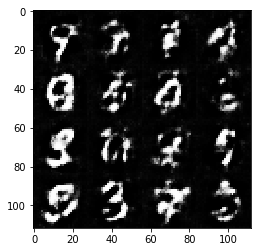

Epoch 1/2... Discriminator Loss: 0.4547... Generator Loss: 2.5681
Epoch 1/2... Discriminator Loss: 0.5746... Generator Loss: 1.8578
Epoch 1/2... Discriminator Loss: 0.6626... Generator Loss: 3.9326
Epoch 1/2... Discriminator Loss: 0.4514... Generator Loss: 2.5961
Epoch 1/2... Discriminator Loss: 0.4675... Generator Loss: 3.2697
Epoch 1/2... Discriminator Loss: 0.4844... Generator Loss: 3.0279
Epoch 1/2... Discriminator Loss: 0.6648... Generator Loss: 1.6048
Epoch 1/2... Discriminator Loss: 0.4379... Generator Loss: 2.7887
Epoch 1/2... Discriminator Loss: 0.4145... Generator Loss: 3.0149
Epoch 1/2... Discriminator Loss: 0.4192... Generator Loss: 3.1477


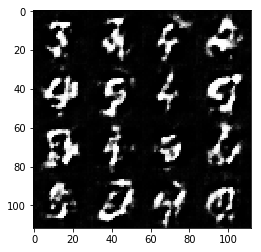

Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 2.2551
Epoch 1/2... Discriminator Loss: 0.4337... Generator Loss: 2.9260
Epoch 1/2... Discriminator Loss: 0.5014... Generator Loss: 2.1410
Epoch 1/2... Discriminator Loss: 0.4381... Generator Loss: 4.2101
Epoch 1/2... Discriminator Loss: 0.5029... Generator Loss: 2.1832
Epoch 1/2... Discriminator Loss: 0.4496... Generator Loss: 3.0330
Epoch 1/2... Discriminator Loss: 0.4283... Generator Loss: 2.8819
Epoch 1/2... Discriminator Loss: 0.5013... Generator Loss: 2.2374
Epoch 1/2... Discriminator Loss: 0.4135... Generator Loss: 3.6158
Epoch 1/2... Discriminator Loss: 0.4678... Generator Loss: 2.4287


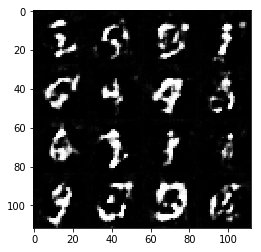

Epoch 1/2... Discriminator Loss: 0.9096... Generator Loss: 1.3795
Epoch 1/2... Discriminator Loss: 0.4249... Generator Loss: 3.5345
Epoch 1/2... Discriminator Loss: 0.4391... Generator Loss: 3.2335
Epoch 1/2... Discriminator Loss: 0.4045... Generator Loss: 3.1971
Epoch 1/2... Discriminator Loss: 0.4429... Generator Loss: 3.1173
Epoch 1/2... Discriminator Loss: 0.4203... Generator Loss: 3.2335
Epoch 1/2... Discriminator Loss: 0.4406... Generator Loss: 2.8269
Epoch 1/2... Discriminator Loss: 0.6787... Generator Loss: 1.6033
Epoch 1/2... Discriminator Loss: 0.4402... Generator Loss: 3.1808
Epoch 1/2... Discriminator Loss: 0.4914... Generator Loss: 2.2494


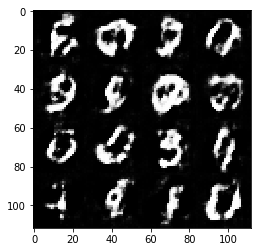

Epoch 1/2... Discriminator Loss: 0.4110... Generator Loss: 3.1864
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 3.3287
Epoch 1/2... Discriminator Loss: 0.4297... Generator Loss: 3.6186
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 4.9262
Epoch 1/2... Discriminator Loss: 0.4227... Generator Loss: 4.3800
Epoch 1/2... Discriminator Loss: 0.4962... Generator Loss: 3.8375
Epoch 1/2... Discriminator Loss: 0.4736... Generator Loss: 2.6746
Epoch 1/2... Discriminator Loss: 0.4349... Generator Loss: 2.7058
Epoch 1/2... Discriminator Loss: 0.4515... Generator Loss: 2.6052
Epoch 1/2... Discriminator Loss: 0.4113... Generator Loss: 3.2915


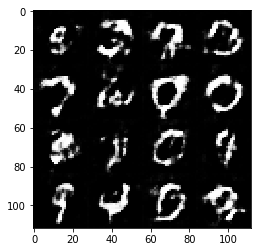

Epoch 1/2... Discriminator Loss: 0.4283... Generator Loss: 2.9032
Epoch 1/2... Discriminator Loss: 0.4252... Generator Loss: 3.2051
Epoch 1/2... Discriminator Loss: 0.4226... Generator Loss: 2.9016
Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 3.7817
Epoch 2/2... Discriminator Loss: 0.4044... Generator Loss: 3.0436
Epoch 2/2... Discriminator Loss: 0.4360... Generator Loss: 3.4463
Epoch 2/2... Discriminator Loss: 0.4502... Generator Loss: 3.2589
Epoch 2/2... Discriminator Loss: 0.4106... Generator Loss: 3.1589
Epoch 2/2... Discriminator Loss: 0.4714... Generator Loss: 2.7871
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 2.4879


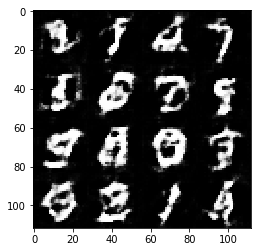

Epoch 2/2... Discriminator Loss: 0.4105... Generator Loss: 3.2058
Epoch 2/2... Discriminator Loss: 0.4289... Generator Loss: 3.1719
Epoch 2/2... Discriminator Loss: 0.4637... Generator Loss: 2.4798
Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 1.7841
Epoch 2/2... Discriminator Loss: 0.4366... Generator Loss: 4.4072
Epoch 2/2... Discriminator Loss: 0.4334... Generator Loss: 3.8821
Epoch 2/2... Discriminator Loss: 0.4752... Generator Loss: 2.5196
Epoch 2/2... Discriminator Loss: 0.4186... Generator Loss: 2.8296
Epoch 2/2... Discriminator Loss: 0.4716... Generator Loss: 2.3759
Epoch 2/2... Discriminator Loss: 1.2318... Generator Loss: 0.7999


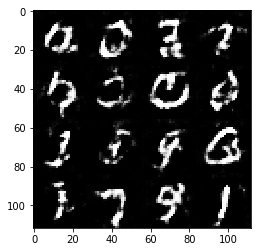

Epoch 2/2... Discriminator Loss: 0.4091... Generator Loss: 3.9001
Epoch 2/2... Discriminator Loss: 0.4259... Generator Loss: 3.2342
Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 4.2524
Epoch 2/2... Discriminator Loss: 0.4133... Generator Loss: 3.2729
Epoch 2/2... Discriminator Loss: 0.6088... Generator Loss: 1.7903
Epoch 2/2... Discriminator Loss: 0.4908... Generator Loss: 3.0648
Epoch 2/2... Discriminator Loss: 0.4666... Generator Loss: 2.6317
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 4.2499
Epoch 2/2... Discriminator Loss: 0.3949... Generator Loss: 3.6006


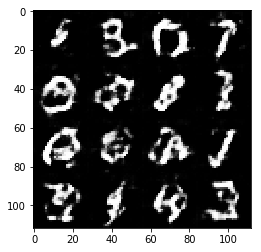

Epoch 2/2... Discriminator Loss: 0.4339... Generator Loss: 3.4775
Epoch 2/2... Discriminator Loss: 0.5583... Generator Loss: 3.9965
Epoch 2/2... Discriminator Loss: 0.5293... Generator Loss: 2.8702
Epoch 2/2... Discriminator Loss: 0.4338... Generator Loss: 2.8414
Epoch 2/2... Discriminator Loss: 0.7741... Generator Loss: 4.2880
Epoch 2/2... Discriminator Loss: 0.4633... Generator Loss: 3.0469
Epoch 2/2... Discriminator Loss: 0.5001... Generator Loss: 2.2057
Epoch 2/2... Discriminator Loss: 0.4409... Generator Loss: 2.8616
Epoch 2/2... Discriminator Loss: 0.4260... Generator Loss: 3.6058
Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 3.0463


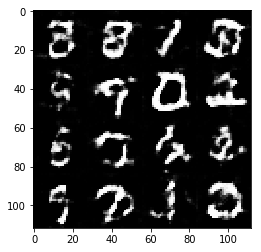

Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 2.7134
Epoch 2/2... Discriminator Loss: 0.6559... Generator Loss: 3.3189
Epoch 2/2... Discriminator Loss: 0.4180... Generator Loss: 3.0640
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 5.2238
Epoch 2/2... Discriminator Loss: 0.4914... Generator Loss: 2.5711
Epoch 2/2... Discriminator Loss: 0.5919... Generator Loss: 1.8807
Epoch 2/2... Discriminator Loss: 0.4593... Generator Loss: 3.8200
Epoch 2/2... Discriminator Loss: 0.4158... Generator Loss: 3.0747
Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 3.5653
Epoch 2/2... Discriminator Loss: 0.9141... Generator Loss: 1.1021


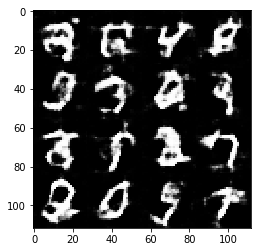

Epoch 2/2... Discriminator Loss: 0.6152... Generator Loss: 1.7099
Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 3.1080
Epoch 2/2... Discriminator Loss: 0.4186... Generator Loss: 3.0527
Epoch 2/2... Discriminator Loss: 0.4049... Generator Loss: 3.5999
Epoch 2/2... Discriminator Loss: 0.6822... Generator Loss: 3.3744
Epoch 2/2... Discriminator Loss: 0.4463... Generator Loss: 2.6970
Epoch 2/2... Discriminator Loss: 0.4730... Generator Loss: 2.3715
Epoch 2/2... Discriminator Loss: 0.4176... Generator Loss: 3.3255
Epoch 2/2... Discriminator Loss: 0.5022... Generator Loss: 3.7613
Epoch 2/2... Discriminator Loss: 0.4894... Generator Loss: 2.3091


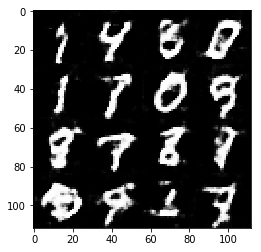

Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 1.9204
Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 3.4313
Epoch 2/2... Discriminator Loss: 0.4028... Generator Loss: 3.5155
Epoch 2/2... Discriminator Loss: 0.4021... Generator Loss: 3.4512
Epoch 2/2... Discriminator Loss: 0.4277... Generator Loss: 2.7423
Epoch 2/2... Discriminator Loss: 0.6989... Generator Loss: 3.9814
Epoch 2/2... Discriminator Loss: 0.4525... Generator Loss: 2.9188
Epoch 2/2... Discriminator Loss: 0.4498... Generator Loss: 2.6912
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.1712
Epoch 2/2... Discriminator Loss: 0.4957... Generator Loss: 2.2901


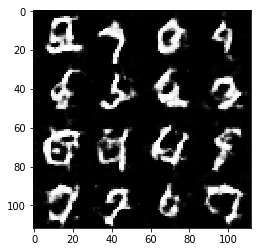

Epoch 2/2... Discriminator Loss: 0.5685... Generator Loss: 1.8705
Epoch 2/2... Discriminator Loss: 0.5846... Generator Loss: 1.8644
Epoch 2/2... Discriminator Loss: 0.5881... Generator Loss: 1.8093
Epoch 2/2... Discriminator Loss: 0.4926... Generator Loss: 2.9847
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 1.9328
Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 2.4745
Epoch 2/2... Discriminator Loss: 0.4152... Generator Loss: 3.0061
Epoch 2/2... Discriminator Loss: 0.5001... Generator Loss: 2.3272
Epoch 2/2... Discriminator Loss: 0.4126... Generator Loss: 3.3396
Epoch 2/2... Discriminator Loss: 0.4825... Generator Loss: 2.3115


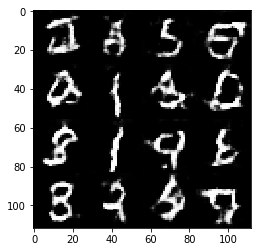

Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.8356
Epoch 2/2... Discriminator Loss: 0.6018... Generator Loss: 1.7046
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 1.0389
Epoch 2/2... Discriminator Loss: 0.4911... Generator Loss: 2.4642
Epoch 2/2... Discriminator Loss: 0.5223... Generator Loss: 3.6695
Epoch 2/2... Discriminator Loss: 0.4280... Generator Loss: 2.9890
Epoch 2/2... Discriminator Loss: 0.4621... Generator Loss: 2.5204
Epoch 2/2... Discriminator Loss: 0.5077... Generator Loss: 2.1553
Epoch 2/2... Discriminator Loss: 0.4330... Generator Loss: 4.1870
Epoch 2/2... Discriminator Loss: 0.6786... Generator Loss: 1.8255


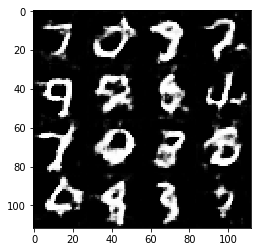

Epoch 2/2... Discriminator Loss: 0.7675... Generator Loss: 2.2151
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 1.5824
Epoch 2/2... Discriminator Loss: 0.4676... Generator Loss: 2.5237
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 2.3822
Epoch 2/2... Discriminator Loss: 0.6200... Generator Loss: 1.6972
Epoch 2/2... Discriminator Loss: 0.4726... Generator Loss: 2.4968
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 1.3413


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.